In [84]:
#import importlib
#import Compute_evolution_of_clusters
#importlib.reload(Compute_evolution_of_clusters)
#from Compute_evolution_of_clusters import *
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import sys

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Analysis/')
sys.path.append('/home/hugo/PostDoc/aging_condensates/Gillespie/Analysis/')
from ToolBox import *

sys.path.append('/home/hcleroy/Extra_Module_py')
sys.path.append('/home/hugo/Extra_Module_py')
import formated_matplotlib

Ec = lambda L,N : 3/2*np.log(L/N* np.pi/3)

sys.path.append('/home/hcleroy/PostDoc/aging_condensates/Simulation/Gillespie/Gillespie_backend/')
sys.path.append('/home/hugo/PostDoc/aging_condensates/Gillespie/Gillespie_backend/')
import Gillespie_backend as gil


In [2]:
# gillespie parameter
Nlinker = 20
ell_tot = 10**3
V = 2*((ell_tot/6)**1.5/Nlinker**0.5*3/4*np.pi)
#kdiff = 100/(V) # for 3D
kdiff = 1.
Energy = -15
Nprocess = 10
args = [[ell_tot,Energy,kdiff,np.random.randint(1000000),Nlinker,3] for _ in range(Nprocess)]
print(Ec(ell_tot,Nlinker))
# Simulation parameters
step_tot = 200000
compute_steps = 10000

5.937210903914155


In [69]:
gillespie = gil.Gillespie(ell_tot=ell_tot, rho0=0., BindingEnergy=Energy, kdiff=kdiff,
                            seed=6542, sliding=False, Nlinker=Nlinker, old_gillespie=None, dimension=3)

def compute_MSD(gillespie,output,step_tot,check_steps,q_vector):
    msd_time = np.zeros((step_tot//check_steps,2),dtype=float)
    r_cumul = np.zeros(gillespie.N,dtype=float)  # the cumulated displacement of the particles
    initial_positions = gillespie.get_r()
    current_time = 0
    prev_position = gillespie.get_r()
    for n in range((step_tot//check_steps)):
        for t in range(check_steps):
            move,time = gillespie.evolve()
            current_time += np.sum(time)
            if move[0] == 1:
                dr = gillespie.get_r() - prev_position # vector of dimension N x 3
                prev_position = gillespie.get_r()

                part_cross_boundary = np.argwhere(np.linalg.norm(dr)>1)
                if np.linalg.norm(dr)>1.:
                    # reajust the value of dr
                    dr = 
                r_cumul+=dr
            msd_time[n] = [current_time, np.mean(dr**2)]
    return msd_time

In [56]:
def Follow_trajectory(gillespie,step_tot,periodic = False):
    trajectory = np.zeros((step_tot,gillespie.Nlinker,3),dtype=float)
    time = np.zeros(step_tot,dtype=float)
    for t in range(step_tot):
        trajectory[t] = gillespie.get_r(periodic)
        move,dt = gillespie.evolve()        
        if t>1:
            time[t] = time[t-1]+dt[0]
        else:
            time[t] =dt[0]
    return trajectory,time


In [57]:
trajectories,time = Follow_trajectory(gillespie,10000,True)

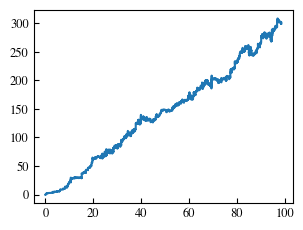

In [58]:
plt.plot(time,np.mean(np.linalg.norm(trajectories-trajectories[0],axis=2)**2,axis=1))
#plt.xlim(0,0.2*10**(-6))
#plt.ylim(-0.5,1)

In [92]:
def compute_MSD(gillespie,output,step_tot,check_steps,q_vector):        
    msd_time_list = list()
    for n in range((step_tot//check_steps)):
        current_time = 0
        #msd_time = np.zeros((step_tot//check_steps,2),dtype=float)
        initial_positions = gillespie.get_r(periodic = True)
        move,time = gillespie.evolve(check_steps)
        current_time += np.sum(time)
        msd_time = np.array([current_time, np.mean(np.linalg.norm(initial_positions - gillespie.get_r(periodic=True),axis=2)**2)])
        msd_time_list.append(msd_time)
    return msd_time_list
            

In [93]:
MSD_t = compute_MSD(gillespie,None,10000,1000,None)

AxisError: axis 2 is out of bounds for array of dimension 2

In [91]:
print(MSD_t[0])

[10.89833659 25.34643562]


In [89]:

cmap = cm.get_cmap('viridis')
for i,msd_t in enumerate(MSD_t):
    plt.scatter(msd_t[:,0],msd_t[:,1],color = cmap(i/10))

/tmp/ipykernel_50012/3837560282.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [3]:
average_result_b = np.zeros((step_tot//compute_steps,2),dtype=float)
with pt.open_file('c_size_20_linkers_Ell_10E3_b.hdf','r') as file:
    n = 0
    for array in file.list_nodes('/',classname='Array'):
        average_result_b+=array
        n+=1
    average_result_b /= n

In [4]:
with pt.open_file('c_size_20_linkers_Ell_10E3_b.hdf','r') as file:
    print(file.list_nodes)

<bound method File.list_nodes of File(filename=c_size_20_linkers_Ell_10E3_b.hdf, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/av_clust_size_0x3488d (Array(20, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/av_clust_size_0x45382 (Array(20, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/av_clust_size_0x6c91e (Array(20, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/av_clust_size_0x77420 (Array(20, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/av_clust_size_0x7a643 (Array(20, 2)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavo

In [10]:
average_result = np.zeros((step_tot//compute_steps,2),dtype=float)
with pt.open_file('c_size_20_linkers_Ell_10E3.hdf','r') as file:
    n = 0
    for array in file.list_nodes('/',classname='Array'):
        average_result+=array
        n+=1
    average_result /= n

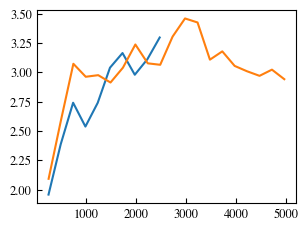

In [16]:
plt.plot(average_result[:,0],average_result[:,1])
plt.plot(average_result_b[:,0],average_result_b[:,1])